In [3]:
pip install requests networkx


Note: you may need to restart the kernel to use updated packages.


# Bước 1: Chuẩn bị môi trường & API key

In [4]:
import json
import pandas as pd
import re
import os
from pathlib import Path
import time
import hashlib
from itertools import islice
import requests
import networkx as nx
from dotenv import load_dotenv
import  random
from itertools import islice
import networkx as nx



In [5]:
# Load API key
load_dotenv()
API_KEY = os.getenv("STEAM_API_KEY")
if not API_KEY:
    raise SystemExit("Please set STEAM_API_KEY in environment or .env file")

BASE = "https://api.steampowered.com"
CACHE_DIR = Path("steam_cache")
CACHE_DIR.mkdir(exist_ok=True)

DELAY_BETWEEN_REQUESTS = 0.5
BATCH_SIZE = 50
MAX_ACHIEVEMENTS_APPS = 3
REQUEST_TIMEOUT = 15


# STEAM CRAWLER - full functions (cache, API, endpoints, BFS crawler, save outputs)
- Cache để tránh request trùng
- API request với backoff, skip private
- Các endpoint Steam: summaries, friends, owned games, recently played, groups, bans, achievements
- BFS crawl nhiều batch, skip user/private, merge cuối cùng
- Safe với NetworkX GEXF (loại bỏ NoneType)

In [6]:
# %% 
"""
STEAM CRAWLER - SAFE THROTTLED + CHECKPOINT
--------------------------------------------
- Cache tránh request trùng
- API request với backoff & throttle
- BFS crawl nhiều batch
- Lưu checkpoint mỗi N user
- In progress để theo dõi tiến trình
"""

# ================================
# Cache utils
# ================================
CACHE_DIR = Path("steam_cache")
CACHE_DIR.mkdir(exist_ok=True)

def cache_key(endpoint, params):
    s = endpoint + json.dumps(params, sort_keys=True)
    return hashlib.sha1(s.encode("utf-8")).hexdigest()

def cache_load(endpoint, params):
    k = cache_key(endpoint, params)
    p = CACHE_DIR / f"{k}.json"
    if p.exists():
        try:
            return json.loads(p.read_text(encoding="utf-8"))
        except Exception:
            return None
    return None

def cache_save(endpoint, params, data):
    k = cache_key(endpoint, params)
    p = CACHE_DIR / f"{k}.json"
    p.write_text(json.dumps(data, ensure_ascii=False, indent=2), encoding="utf-8")

# ================================
# Config crawl
# ================================
DELAY_MIN = 1.0
DELAY_MAX = 2.0
BATCH_SIZE = 50
MAX_APPS_PER_USER = 3
REQUEST_TIMEOUT = 15
CHECKPOINT_EVERY = 50
BASE = "https://api.steampowered.com"
API_KEY = os.getenv("STEAM_API_KEY")

# ================================
# API request with backoff & throttle
# ================================
def api_get(endpoint, params, use_cache=True):
    params = dict(params)
    params["key"] = API_KEY
    if use_cache:
        cached = cache_load(endpoint, params)
        if cached is not None:
            return cached

    url = f"{BASE}/{endpoint}"
    backoff = 1.0
    for attempt in range(6):
        try:
            r = requests.get(url, params=params, timeout=REQUEST_TIMEOUT)
            if r.status_code == 200:
                try: data = r.json()
                except ValueError: data = r.text
                cache_save(endpoint, params, data)
                time.sleep(random.uniform(DELAY_MIN, DELAY_MAX))
                return data
            elif r.status_code in (429, 503):
                time.sleep(backoff + random.uniform(0.1,0.5))
                backoff *= 2
            elif r.status_code in (401,403):
                print(f"[PRIVATE] skip: {params}")
                return {"private": True}
            else:
                print(f"[WARN] {r.status_code} from {url} params={params}")
                return None
        except requests.RequestException as e:
            print(f"[WARN] Request exception {e}, backoff {backoff}s")
            time.sleep(backoff + random.uniform(0.1,0.5))
            backoff *= 2
    print("[ERROR] Max retries exceeded for", url)
    return None


# Helper chunks
def chunks(iterable, n):
    it = iter(iterable)
    while True:
        chunk = list(islice(it, n))
        if not chunk: break
        yield chunk


# Steam endpoints
def get_player_summaries(steamid_list):
    endpoint="ISteamUser/GetPlayerSummaries/v0002/"; results=[]
    for batch in chunks(steamid_list,BATCH_SIZE):
        params={"steamids":",".join(batch)}
        data=api_get(endpoint,params)
        if data and not data.get("private"):
            results.extend(data.get("response",{}).get("players",[]))
    return results

def get_friend_list(steamid):
    endpoint="ISteamUser/GetFriendList/v0001/"
    params={"steamid":steamid,"relationship":"friend"}
    data=api_get(endpoint,params)
    if data and data.get("private"): return []
    return [f.get("steamid") for f in data.get("friendslist",{}).get("friends",[])] if data else []

def get_owned_games(steamid):
    endpoint="IPlayerService/GetOwnedGames/v0001/"
    params={"steamid":steamid,"include_appinfo":1,"include_played_free_games":1,"format":"json"}
    data=api_get(endpoint,params)
    if data and data.get("private"): return {}
    return data.get("response",{}) if data else {}

def get_recently_played(steamid):
    endpoint="IPlayerService/GetRecentlyPlayedGames/v0001/"
    params={"steamid":steamid}
    data=api_get(endpoint,params)
    if data and data.get("private"): return {}
    return data.get("response",{}) if data else {}

def get_user_groups(steamid):
    endpoint="ISteamUser/GetUserGroupList/v1/"
    params={"steamid":steamid}
    data=api_get(endpoint,params)
    if data and data.get("private"): return []
    return data.get("response",{}).get("groups",[]) if data else []

def get_player_bans(steamid_list):
    endpoint="ISteamUser/GetPlayerBans/v1/"; results=[]
    for batch in chunks(steamid_list,BATCH_SIZE):
        params={"steamids":",".join(batch)}
        data=api_get(endpoint,params)
        if data and not data.get("private"): results.extend(data.get("players",[]))
    return results

def get_player_achievements(steamid,appid):
    endpoint="ISteamUserStats/GetPlayerAchievements/v1/"
    params={"steamid":steamid,"appid":appid}
    data=api_get(endpoint,params)
    if data and data.get("private"): return {}
    return data.get("playerstats",{}) if data else {}

def resolve_vanity(name):
    endpoint="ISteamUser/ResolveVanityURL/v0001/"
    params={"vanityurl":name}
    data=api_get(endpoint,params)
    if data and data.get("response",{}).get("success")==1:
        return data["response"].get("steamid")
    return None

# Load existing profiles
def load_existing_profiles(json_path):
    if Path(json_path).exists():
        with open(json_path,"r",encoding="utf-8") as f:
            data=json.load(f)
        return set(data.keys()), data
    return set(), {}

# Save outputs
def save_outputs(G, profiles, out_prefix="steam_output"):
    # Clean node attributes
    for n, data in G.nodes(data=True):
        for k, v in list(data.items()):
            if v is None: data[k] = ""
            elif isinstance(v,(list,dict)): data[k]=str(v)
    json_path=f"{out_prefix}_profiles1.json"
    with open(json_path,"w",encoding="utf-8") as f: json.dump(profiles,f,indent=2,ensure_ascii=False)
    gexf_path=f"{out_prefix}_graph1.gexf"
    nx.write_gexf(G,gexf_path)
    print(f"[Saved] profiles -> {json_path}")
    print(f"[Saved] graph -> {gexf_path}")


# BFS crawler with checkpoint
def crawl(seed_ids, depth=1, max_users=1000, max_apps_per_user=3, visited_global=None, save_prefix="steam_output", fetch_achievements=True):
    G = nx.Graph()
    visited_global = visited_global or set()
    queue = [(s,0) for s in seed_ids]
    all_profiles = {}
    stats = {"public":0,"private":0,"skipped":0}

    while queue and len(visited_global)<max_users:
        steamid, d = queue.pop(0)
        if steamid in visited_global or d>depth: continue
        if not steamid.isdigit(): steamid=resolve_vanity(steamid) or steamid
        if not steamid.isdigit(): stats["skipped"]+=1; continue

        print(f"Crawling {steamid} (depth {d}) | Visited {len(visited_global)}/{max_users}")

        players = get_player_summaries([steamid])
        if not players:
            stats["private"]+=1
            visited_global.add(steamid)
            continue

        player = players[0]
        visited_global.add(steamid)
        stats["public"]+=1
        all_profiles[steamid] = player

        G.add_node(steamid,label=player.get("personaname",""),
                   avatar=player.get("avatarfull",""),
                   country=player.get("loccountrycode",""))

        friends = get_friend_list(steamid)
        for f in friends:
            G.add_edge(steamid,f)
            if f not in visited_global and d+1<=depth:
                queue.append((f,d+1))

        owned = get_owned_games(steamid)
        recent = get_recently_played(steamid)
        groups = get_user_groups(steamid)

        G.nodes[steamid]["owned_game_count"] = owned.get("game_count",0)
        G.nodes[steamid]["recent_count"] = recent.get("total_count",0)
        G.nodes[steamid]["groups"] = [g.get("groupid64") for g in groups] if groups else []

        apps = owned.get("games",[]) if isinstance(owned,dict) else []
        top_apps = sorted(apps, key=lambda x:x.get("playtime_forever",0), reverse=True)[:max_apps_per_user]
        G.nodes[steamid]["top_apps"] = [a.get("appid") for a in top_apps]

        # Achievements (optional, tốn thời gian)
        if fetch_achievements:
            achievements={}
            for app in top_apps: achievements[app.get("appid")] = get_player_achievements(steamid, app.get("appid"))
            G.nodes[steamid]["achievements_sample"] = achievements

        # Checkpoint every N users
        if len(visited_global) % CHECKPOINT_EVERY == 0:
            save_outputs(G, all_profiles, out_prefix=f"{save_prefix}_partial")
            print(f"[Checkpoint] Saved after {len(visited_global)} users")

    # Final bans
    bans = get_player_bans(list(visited_global))
    bans_map = {b["SteamId"]:b for b in bans}
    for node in G.nodes:
        G.nodes[node]["ban_info"] = bans_map.get(node,{})

    save_outputs(G, all_profiles, out_prefix=save_prefix)
    print(f"Stats: {stats}")
    return G, all_profiles, visited_global


# Example run
visited_prev, profiles_prev = load_existing_profiles("steam_output_test_profiles1.json")
SEEDS = ["76561198294300457","76561197973974836"]  # Thay bằng steamid của bạn

G_new, profiles_new, visited_new = crawl(
    SEEDS,
    depth=2,
    max_users=5000,
    max_apps_per_user=3,
    visited_global=visited_prev,
    save_prefix="steam_output",
    fetch_achievements=False  # Test nhanh trước
)


Crawling 76561198294300457 (depth 0) | Visited 0/5000
Crawling 76561197973974836 (depth 0) | Visited 1/5000
Crawling 76561197993609350 (depth 1) | Visited 2/5000
Crawling 76561198046562139 (depth 1) | Visited 3/5000
Crawling 76561198061953477 (depth 1) | Visited 4/5000
Crawling 76561198062226249 (depth 1) | Visited 5/5000
Crawling 76561198076766555 (depth 1) | Visited 6/5000
Crawling 76561198077186687 (depth 1) | Visited 7/5000
Crawling 76561198097199951 (depth 1) | Visited 8/5000
Crawling 76561198109776027 (depth 1) | Visited 9/5000
Crawling 76561198110181817 (depth 1) | Visited 10/5000
Crawling 76561198116685130 (depth 1) | Visited 11/5000
Crawling 76561198120611517 (depth 1) | Visited 12/5000
Crawling 76561198128339070 (depth 1) | Visited 13/5000
Crawling 76561198134815732 (depth 1) | Visited 14/5000
Crawling 76561198135035013 (depth 1) | Visited 15/5000
Crawling 76561198138224835 (depth 1) | Visited 16/5000
[PRIVATE] skip: {'steamid': '76561198138224835', 'relationship': 'friend', 

--------------------------------------------------------------------------------------------------------------------------

# Phân loại category cho steam_cache (game, group, friends, summaries, achievements)

In [ ]:
import os
import json

def merge_json_files(input_dir, output_file):

    merged_data = {}

    for filename in os.listdir(input_dir):
        if filename.endswith(".json"):
            file_path = os.path.join(input_dir, filename)
            try:
                with open(file_path, "r", encoding="utf-8") as f:
                    data = json.load(f)

                    # Nếu dữ liệu có steamid thì dùng làm key
                    steamid = data.get("steamid") or data.get("id") or filename
                    merged_data[steamid] = data

            except json.JSONDecodeError:
                print(f" Lỗi đọc JSON: {file_path}, bỏ qua...")
            except Exception as e:
                print(f" Lỗi khác với file {file_path}: {e}")

    # Lưu lại thành 1 file JSON duy nhất
    with open(output_file, "w", encoding="utf-8") as out:
        json.dump(merged_data, out, ensure_ascii=False, indent=2)

    print(f" Đã gộp {len(merged_data)} file từ {input_dir} vào {output_file}")

merge_json_files("steam_cache/games", "merged_games.json")
merge_json_files("steam_cache/summaries", "merged_summaries.json")
merge_json_files("steam_cache/achievements", "merged_achievements.json")
merge_json_files("steam_cache/friends", "merged_friends.json")
merge_json_files("steam_cache/groups", "merged_groups.json")


✅ Đã gộp 1502 file từ steam_cache/games vào merged_games.json
✅ Đã gộp 1951 file từ steam_cache/summaries vào merged_summaries.json
✅ Đã gộp 491 file từ steam_cache/achievements vào merged_achievements.json
✅ Đã gộp 1583 file từ steam_cache/friends vào merged_friends.json
✅ Đã gộp 1800 file từ steam_cache/groups vào merged_groups.json


---------------------------------------------------------------------------------------------------------------

## CHUẨN HÓA CÁC FILE THÀNH CHUẨN CSV

CHUẨN HÓA FILE games.json


In [ ]:
import json
import pandas as pd

#  1. Đọc file JSON gốc 
with open("steam_cache/steam_cache_json/games.json", "r", encoding="utf-8") as f:  # thay đường dẫn vào đây
    data = json.load(f)

rows = []

# 2. Duyệt qua từng user (key = sha1_id)
for sha1_id, content in data.items():
    resp = content.get("response", {})
    games = resp.get("games", [])
    
    for g in games:
        rows.append({
            "sha1_id": sha1_id,
            "appid": g.get("appid"),
            "name": g.get("name"),
            "playtime_forever": g.get("playtime_forever"),
            "playtime_2weeks": g.get("playtime_2weeks"),
            "img_icon_url": g.get("img_icon_url"),
            "content_descriptorids": ",".join(map(str, g.get("content_descriptorids", [])))
        })

# 3. Chuyển sang DataFrame 
df = pd.DataFrame(rows)

#  4. Xuất ra CSV 
df.to_csv("games_flat.csv", index=False, encoding="utf-8-sig")

print(f"Đã lưu {len(df)} dòng vào games_flat.csv")


✅ Đã lưu 231102 dòng vào games_flat.csv


CHUẨN HÓA FILE FRIENDS

In [10]:
import json
import pandas as pd
import os

def friends_json_to_csv(input_filepath, output_filepath='all_users_friends_flattened.csv'):
    
    # 1. Kiểm tra file đầu vào
    if not os.path.exists(input_filepath):
        print(f" Không tìm thấy file JSON : {input_filepath}")
        return
    
    # 2. Đọc và tải dữ liệu JSON
    try:
        with open(input_filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except json.JSONDecodeError as e:
        print(f" Lỗi phân tích JSON trong file. Vui lòng kiểm tra định dạng: {e}")
        return
    except Exception as e:
        print(f"Lỗi khi đọc file: {e}")
        return
    
    # 3. Chuẩn bị danh sách chứa dữ liệu phẳng
    flat_data = []

    # 4. Lặp qua từng người dùng (key là SHA-1 ID)
    # Key này chính là định danh của người dùng sở hữu danh sách bạn bè (Owner)
    for owner_id_key, content in data.items():
        steamID_Owner = owner_id_key.replace(".json", "")
        
        # Đảm bảo cấu trúc 'friendslist' và 'friends'
        if content and 'friendslist' in content and 'friends' in content['friendslist']:
            
            # 5. Lặp qua danh sách bạn bè
            for friend in content['friendslist']['friends']:
                row = {
                    'steamID_Owner': steamID_Owner,
                    'steamid_Friend': friend.get('steamid'),
                    'relationship': friend.get('relationship'),
                    'friend_since': friend.get('friend_since')
                }
                flat_data.append(row)

    # 6. Tạo DataFrame Pandas và ghi ra CSV
    df = pd.DataFrame(flat_data)
    
    if not df.empty:
        df.to_csv(output_filepath, index=False)
        print("-" * 60)
        print(f"  Dữ liệu ({len(df)} hàng) đã được chuyển đổi và lưu vào file '{output_filepath}'.")
        print("-" * 60)
    else:
        print("Không tìm thấy mối quan hệ bạn bè nào để ghi ra CSV.")


# --- CẤU HÌNH THỰC THI ---
# THAY THẾ đường dẫn dưới đây bằng đường dẫn chính xác của file JSON gốc của bạn
INPUT_FILE = 'steam_cache/steam_cache_json/friends.json'
OUTPUT_FILE = 'friends1.csv'

# Thực thi hàm chuyển đổi
friends_json_to_csv(INPUT_FILE, OUTPUT_FILE)

Bắt đầu đọc dữ liệu từ: steam_cache/steam_cache_json/friends.json...
------------------------------------------------------------
✅ THÀNH CÔNG: Dữ liệu (283784 hàng) đã được chuyển đổi và lưu vào file 'friends1.csv'.
------------------------------------------------------------


CHUẨN HÓA FILE Achievements

In [9]:
import json
import pandas as pd
import os

def flatten_json_file_to_csv(input_filepath, output_filepath):
   
    # 1. Kiểm tra file đầu vào
    if not os.path.exists(input_filepath):
        print(f" Không tìm thấy file JSON tại đường dẫn: {input_filepath}")
        return

    print(f"Bắt đầu đọc dữ liệu từ: {input_filepath}...")
    
    # 2. Đọc và tải dữ liệu JSON
    try:
        with open(input_filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except json.JSONDecodeError as e:
        print(f"Lỗi phân tích JSON trong file: {e}")
        return
    except Exception as e:
        print(f" Lỗi khi đọc file: {e}")
        return
    
    # 3. Chuẩn bị danh sách chứa dữ liệu phẳng
    flat_data = []

    # 4. Lặp qua từng mục (
    # 'data' là một dictionary, với key là tên file và value là nội dung 
    for file_name, file_content in data.items():
        
        # Đảm bảo cấu trúc cần thiết tồn tại
        if file_content and 'playerstats' in file_content:
            playerstats = file_content['playerstats']
            
            # Trích xuất các trường cấp trên (lặp lại)
            steam_id = playerstats.get('steamID')
            game_name = playerstats.get('gameName')
            
            # Chỉ xử lý nếu có danh sách thành tích
            if 'achievements' in playerstats and playerstats['achievements'] is not None:
                
                # 5. Lặp qua từng thành tích
                for achievement in playerstats['achievements']:
                    row = {
                        'steamID': steam_id,
                        'gameName': game_name,
                        'apiname': achievement.get('apiname'),
                        'achieved': achievement.get('achieved'),
                        'unlocktime': achievement.get('unlocktime')
                    }
                    flat_data.append(row)

    # 6. Tạo DataFrame Pandas
    df = pd.DataFrame(flat_data)
    
    # 7. Ghi DataFrame ra file CSV
    if not df.empty:
        df.to_csv(output_filepath, index=False)
        print("-" * 60)
        print(f"THÀNH CÔNG: Dữ liệu ({len(df)} hàng) đã được chuyển đổi và lưu vào file '{output_filepath}'.")
        print("-" * 60)
    else:
        print(" Cảnh báo: Không tìm thấy thành tích nào để ghi ra CSV.")


# --- CẤU HÌNH ---
# THAY THẾ 'ten_file_json_goc_cua_ban.json' BẰNG TÊN FILE CỦA BẠN!
INPUT_FILE = 'steam_cache/steam_cache_json/achievements.json'
OUTPUT_FILE = 'achievements1.csv'

# Thực thi hàm chuyển đổi
# *Lưu ý: Đặt file JSON gốc vào cùng thư mục với file Python này, hoặc cung cấp đường dẫn đầy đủ.*
flatten_json_file_to_csv(INPUT_FILE, OUTPUT_FILE)

Bắt đầu đọc dữ liệu từ: steam_cache/steam_cache_json/achievements.json...
------------------------------------------------------------
✅ THÀNH CÔNG: Dữ liệu (33839 hàng) đã được chuyển đổi và lưu vào file 'achievements1.csv'.
------------------------------------------------------------


chuẩn hóa group

In [14]:
import json
import pandas as pd
import os

def standardize_json_to_temp_csv(input_filepath, temp_filepath):

    if not os.path.exists(input_filepath):
        print(f" Không tìm thấy file JSON tại: {input_filepath}")
        return
        
    print(f"[{temp_filepath}] Bắt đầu đọc và chuẩn hóa dữ liệu JSON...")
    
    try:
        with open(input_filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except Exception as e:
        print(f" Lỗi khi đọc/phân tích JSON: {e}")
        return
    
    flat_data = []

    for owner_id_key, content in data.items():
        sha1_id = owner_id_key.replace(".json", "")
        
        if content and 'response' in content and 'groups' in content['response']:
            for group in content['response']['groups']:
                row = {
                    'sha1_id': sha1_id,
                    'gid': group.get('gid')
                }
                flat_data.append(row)

    df = pd.DataFrame(flat_data)
    
    if df.empty:
        print(" Cảnh báo: Không tìm thấy dữ liệu hợp lệ để chuẩn hóa.")
        return

    df.to_csv(temp_filepath, index=False)
    
    print("-" * 70)
    print(f" BƯỚC 1 HOÀN TẤT: Đã tạo file CSV thô với {len(df)} hàng tại: {temp_filepath}")
    print("-" * 70)

# --- CẤU HÌNH THỰC THI CHO CHƯƠNG TRÌNH 1 ---
INPUT_FILE = 'steam_cache/steam_cache_json/groups.json' # <-- Đổi tên file JSON của bạn
TEMP_CSV_FILE = 'groups1.csv'

standardize_json_to_temp_csv(INPUT_FILE, TEMP_CSV_FILE)

[groups1.csv] Bắt đầu đọc và chuẩn hóa dữ liệu JSON...
----------------------------------------------------------------------
 BƯỚC 1 HOÀN TẤT: Đã tạo file CSV thô với 95051 hàng tại: groups1.csv
----------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------------

# ĐƠN GIẢN HÓA USERID

vÌ trong lúc crawl có nhiều file ko có steamid(user_id) làm ảnh hưởng đến việc mergh dữ liệu, nên sẽ thực hiện add id đơn giãn cho từng users từ trên xuống dưới

Thêm Userid (dựa vào sha1_id ) và tùy theo từng file, mỗi file là một kiểu định dạng trường dữ liệu riêng ( chạy riêng và add cột tùy theo từng file)

In [25]:
import pandas as pd
import os

def rename_users(temp_filepath, final_filepath):
    
    if not os.path.exists(temp_filepath):
        print(f" Lỗi: Không tìm thấy file CSV tạm thời tại: {temp_filepath}")
        print("Vui lòng chạy Chương trình 1 trước.")
        return

    print(f"[{final_filepath}] Bắt đầu định danh lại người dùng...")
    
    try:
        # Đọc file CSV tạm thời
        df = pd.read_csv(temp_filepath)
    except Exception as e:
        print(f"Lỗi khi đọc file CSV tạm thời: {e}")
        return

    if df.empty:
        print(" Cảnh báo: File CSV tạm thời không có dữ liệu.")
        return

    # 1. Ánh xạ SHA1 ID sang User ID mới (User1, User2, ...)
    df['steamid'] = df['steamid'].astype(str).str.strip()
    
    # Lấy danh sách sha1_id duy nhất theo thứ tự xuất hiện
    unique_sha1_ids = df['steamid'].drop_duplicates().tolist()
    
    # Tạo ánh xạ (mapping)
    user_id_map = {
        sha1_id: f"User{i+1}" 
        for i, sha1_id in enumerate(unique_sha1_ids)
    }

    # Áp dụng ánh xạ để tạo cột 'user_id' mới
    df['user_id'] = df['steamid'].map(user_id_map)

    # 2. Ghi ra file CSV cuối cùng
    df = df[['user_id', 'steamid', 'profilestate','personaname', 'avatarfull', 'personastate',
             'realname', 'primaryclanid', 'timecreated','loccountrycode', 'locstatecode']]
    df.to_csv(final_filepath, index=False)
    
    print("-" * 70)
    print(f"BƯỚC 2 HOÀN TẤT: Đã tạo {len(unique_sha1_ids)} User duy nhất.")
    print(f"File CSV cuối cùng đã định dạng lại được lưu tại: {final_filepath}")
    print("-" * 70)

# --- CẤU HÌNH THỰC THI CHO CHƯƠNG TRÌNH 2 ---
TEMP_CSV_FILE = 'profiles_users.csv' # Phải khớp với tên file đầu ra của Chương trình 1
FINAL_OUTPUT_FILE = 'profiles_users1.csv'

rename_users(TEMP_CSV_FILE, FINAL_OUTPUT_FILE)

[profiles_users1.csv] Bắt đầu định danh lại người dùng...
----------------------------------------------------------------------
✅ BƯỚC 2 HOÀN TẤT: Đã tạo 1949 User duy nhất.
File CSV cuối cùng đã định dạng lại được lưu tại: profiles_users1.csv
----------------------------------------------------------------------


XÓA SHA1_id 

sau khi đã có user_id thì thực hiện xóa sha_id để dữ liệu được thoáng và đẹp hơn

In [29]:
import pandas as pd
import os

def delete_column_concise(input_file, output_file):
    """Đọc CSV, xóa cột 'sha1_id', và lưu file mới."""
    
    if not os.path.exists(input_file):
        print(f"❌ Lỗi: Không tìm thấy file tại: {input_file}")
        return

    try:
        df = pd.read_csv(input_file)
        
        # Kiểm tra và xóa cột
        if 'steamid' in df.columns:
            df.drop(columns=['steamid'], inplace=True)
            df.to_csv(output_file, index=False)
            print(f"XONG: Đã xóa cột 'sha1_id'. File mới: {output_file}")
        else:
            print(" Lỗi: Không tìm thấy cột 'sha1_id'. Không có gì để xóa.")
            
    except Exception as e:
        print(f"Lỗi: Đã xảy ra lỗi khi xử lý file: {e}")

# --- THỰC THI ---
INPUT_FILE = 'profiles_users3.csv' 
OUTPUT_FILE = 'profiles_users4.csv'

delete_column_concise(INPUT_FILE, OUTPUT_FILE)

✅ XONG: Đã xóa cột 'sha1_id'. File mới: profiles_users4.csv


GỘP CÁC FILE ĐÃ XỬ LÝ ( Cùng User_id ) 

thực hiện gộp các file lại với nhau để việc tiền xử lý dữ liệu được dễ dàng và thuận lợi, trực quan hơn

đầu tiên thực hiện gộp file achievements vào file user(chính) : bởi vì 2 file này có chung trường dữ liệu là steamid nên chỉ cần map tới là xong, ko cần phải xử lý user_id

In [28]:
import pandas as pd
import os

def merge_user_data_with_game_counts(profiles_file, achievements_file, output_file):
   
    if not os.path.exists(profiles_file) or not os.path.exists(achievements_file):
        print(" Lỗi: Không tìm thấy một hoặc cả hai file đầu vào.")
        return

    print("Bắt đầu đọc và gộp dữ liệu (Thêm số lượng thành tích theo game)...")
    
    try:
        df_profiles = pd.read_csv(profiles_file)
        df_achievements = pd.read_csv(achievements_file)
    except Exception as e:
        print(f"Lỗi khi đọc file CSV: {e}")
        return

    # Chuẩn hóa cột chung
    df_profiles['steamid'] = df_profiles['steamid'].astype(str).str.strip()
    df_achievements['steamid'] = df_achievements['steamid'].astype(str).str.strip()

    if 'gameName' not in df_achievements.columns:
        print(" Lỗi: File achievements.csv thiếu cột 'gameName' (Tên Game).")
        return
    
    # 1. TÍNH SỐ LƯỢNG THÀNH TÍCH MỖI GAME CỦA MỖI USER
    # Gom nhóm theo cả steamid và gameName để đếm số thành tích
    df_game_counts = df_achievements.groupby(['steamid', 'gameName']).size().reset_index(name='achievements_count_per_game')

    # 2. TỔNG HỢP KẾT QUẢ VÀ TÍNH TỔNG SỐ LƯỢNG THÀNH TÍCH
    # Tạo chuỗi "Tên Game (Số lượng)"
    df_game_counts['game_summary'] = (
        df_game_counts['gameName'] + 
        ' (' + 
        df_game_counts['achievements_count_per_game'].astype(str) + 
        ')'
    )

    # Gom nhóm lần 2 theo steamid để tổng hợp các chuỗi và tính tổng số thành tích
    df_achievements_summary = df_game_counts.groupby('steamid').agg(
        # Tổng số thành tích (tính từ cột achivements_count_per_game)
        total_achievements=('achievements_count_per_game', 'sum'),
        # Nối tất cả các chuỗi tóm tắt game thành một
        game_achievements_summary=('game_summary', ' | '.join)
    ).reset_index()

    print(f"File Profiles có {len(df_profiles)} người dùng.")
    print(f"File Achievements có {len(df_achievements_summary)} người dùng duy nhất (đã gom).")

    # 3. Gộp dữ liệu (Left Join)
    df_merged = pd.merge(
        df_profiles, 
        df_achievements_summary, 
        on='steamid', 
        how='left'
    )

    # 4. Ghi ra file CSV cuối cùng
    df_merged.to_csv(output_file, index=False)

    print("-" * 70)
    print(f"HOÀN TẤT: Dữ liệu đã được gộp thành công.")
    print(f"File đã gộp được lưu tại: {output_file}")
    print("-" * 70)


PROFILES_FILE = 'profiles_users.csv'      # File chứa thông tin profile (phần chính)
ACHIEVEMENTS_FILE = 'achievements.csv' # File chứa thông tin thành tích
OUTPUT_MERGED_FILE = 'profiles_users3.csv'
# Thực thi hàm gộp
merge_user_data_with_game_counts(PROFILES_FILE, ACHIEVEMENTS_FILE, OUTPUT_MERGED_FILE)



Bắt đầu đọc và gộp dữ liệu (Thêm số lượng thành tích theo game)...
File Profiles có 1949 người dùng.
File Achievements có 181 người dùng duy nhất (đã gom).
----------------------------------------------------------------------
✅ HOÀN TẤT: Dữ liệu đã được gộp thành công.
File đã gộp được lưu tại: profiles_users3.csv
----------------------------------------------------------------------


Sau dó ta thực hiện tiếp tục gộp 2 file game và groups vào file users( chính ). vì sau khi đã xử lý user_id thì 3 file này đều có cùng trường dữ liệu là user_id.

gộp 2 file games với groups

In [32]:
import pandas as pd
import os

def merge_three_files_fixed(profiles_file, games_file, groups_file, output_file):
    
    # 1. Kiểm tra sự tồn tại của file
    files = [profiles_file, games_file, groups_file]
    if not all(os.path.exists(f) for f in files):
        print(" Lỗi: Không tìm thấy một hoặc nhiều file đầu vào.")
        return

    print("Bắt đầu đọc và gộp dữ liệu từ 3 file...")
    
    try:
        # Đọc dữ liệu
        df_profiles = pd.read_csv(profiles_file)
        df_games = pd.read_csv(games_file)
        df_groups = pd.read_csv(groups_file)
    except Exception as e:
        print(f" Lỗi khi đọc file CSV: {e}")
        return

    # Chuẩn hóa cột chung 'user_id'
    for df in [df_profiles, df_games, df_groups]:
        if 'user_id' not in df.columns:
            print(f" Lỗi: Một trong các file thiếu cột 'user_id'.")
            return
        df['user_id'] = df['user_id'].astype(str).str.strip()

    # --- BƯỚC KHẮC PHỤC LỖI: Đảm bảo 'gid' là chuỗi ---
    if 'gid' in df_groups.columns:
        # CHUYỂN ĐỔI BẮT BUỘC: chuyển cột gid sang chuỗi (str) để hàm .join() hoạt động
        df_groups['gid'] = df_groups['gid'].astype(str).str.strip() 

 


    # --- BƯỚC 3: XỬ LÝ VÀ TỔNG HỢP FILE GROUPS (Sử dụng cột gid đã chuyển đổi) ---
    if 'gid' in df_groups.columns:
        df_groups_summary = df_groups.groupby('user_id').agg(
            total_groups=('gid', 'size'),
            # Phép join giờ đây an toàn vì 'gid' đã là chuỗi
            all_groups_gid=('gid', lambda x: ' | '.join(x.dropna().unique()))
        ).reset_index()
    else:
        print(" Cảnh báo: File groups.csv thiếu cột 'gid'. Đang sử dụng đếm tổng số hàng.")
        df_groups_summary = df_groups.groupby('user_id').agg(
            total_groups=('user_id', 'size')
        ).reset_index()


    # --- BƯỚC 4: GỘP (LEFT JOIN) DỮ LIỆU ---
    
    # 4a. Gộp Profiles và Games
    df_merged = pd.merge(
        df_profiles,  
        on='user_id', 
        how='left' 
    )

    # 4b. Gộp kết quả (df_merged) và Groups
    df_final = pd.merge(
        df_merged, 
        df_groups_summary, 
        on='user_id', 
        how='left' 
    )

    # 5. Ghi ra file CSV cuối cùng
    df_final.to_csv(output_file, index=False)

   
    print(f" HOÀN TẤT: Dữ liệu từ 3 file đã được gộp thành công.")
    print(f"File đã gộp được lưu tại: {output_file}")
 

# --- CẤU HÌNH THỰC THI ---
# THAY THẾ TÊN FILE CỦA BẠN!
PROFILES_FILE = 'profiles_users4.csv'  # File chính (phải có cột user_id)
GROUPS_FILE = 'groups.csv'           # File phụ 2 (phải có cột user_id)
OUTPUT_MERGED_FILE = 'master_user_data.csv'

# Thực thi hàm gộp
merge_three_files_fixed(PROFILES_FILE, GROUPS_FILE, OUTPUT_MERGED_FILE)



Bắt đầu đọc và gộp dữ liệu từ 3 file...
⚠️ Cảnh báo: File games.csv thiếu cột 'game_name'. Đang sử dụng đếm tổng số hàng.
----------------------------------------------------------------------
✅ HOÀN TẤT: Dữ liệu từ 3 file đã được gộp thành công.
File đã gộp được lưu tại: master_user_data.csv
----------------------------------------------------------------------


KeyError: 'total_playtime_forever'

---------------------------------------------------------------------------------------------------------------------

# TIỀN XỬ LÝ DỮ LIỆU

## Xử lý dấu, ký tự, icon trong tên người dùng

In [1]:
import csv
import json

# Đường dẫn file CSV đầu vào và file JSON đầu ra
csv_file_path = 'data_users.csv'
json_file_path = 'data_users1.json'

data = []

# Đọc dữ liệu từ CSV
with open(csv_file_path, mode='r', encoding='utf-8') as csv_file:
    csv_reader = csv.DictReader(csv_file)  # Đọc mỗi dòng thành dict
    for row in csv_reader:
        data.append(row)

# Ghi dữ liệu ra JSON
with open(json_file_path, mode='w', encoding='utf-8') as json_file:
    json.dump(data, json_file, indent=4, ensure_ascii=False)

print(f"Chuyển đổi xong! File JSON được lưu tại {json_file_path}")


Chuyển đổi xong! File JSON được lưu tại data_users1.json


CHỈNH SỬA LẠI TÊN USER - XÓA CÁC KÝ TỰ ĐẶC BIỆT

In [6]:
import pandas as pd
import re
# 1. Đọc JSON VÀ TRÍCH XUẤT DANH SÁCH PROFILES (Đã sửa)
with open("data_users1.json", "r", encoding="utf-8") as f:
    data = json.load(f)

if isinstance(data, dict):
    profiles_list = list(data.values())
else:
    profiles_list = data

# Tạo DataFrame từ danh sách 
df = pd.DataFrame(profiles_list)

# 2. Xử lý cột tên người dùng
def clean_name(name):
    if not isinstance(name, str):
        return ""
    
    # Loại bỏký tự 
    name = re.sub(r"[^a-zA-Z0-9À-ỹ\s]", "", name)

    # Xóa khoảng trắng 
    name = re.sub(r"\s+", " ", name).strip()
    return name

if 'personaname' in df.columns:
    df['personaname'] = df['personaname'].apply(clean_name)
    print("Xử lý xong.")
else:
    print(" Cột lo tồn tại.")

# 3. Lưu ra CSV với UTF-8 
df.to_csv("data_userss.csv", index=False, encoding="utf-8-sig")
print("Dữ liệu đã được lưu")

Xử lý xong.
Dữ liệu đã được lưu


In [ ]:

# Loại bỏ các dòng ko có userid 
#df_clean = df.dropna(subset=['steamid']).copy()

# 2. Xóa CÁC CỘT CÓ GIÁ TRỊ KO QUAN TRỌNG
# Điền giá trị mặc định
#df_clean['commentpermission'].fillna(0, inplace=True)

# Xóa các cột ( không quan trọng, thiếu nhiều)
#df_clean = df_clean.drop(['loccityid', 'gameextrainfo', 'gameid', 'lobbysteamid', 'gameserverip', 'gameserversteamid'], axis=1)



# TÌM DỮ LIỆU THIẾU


In [7]:
import pandas as pd


# Bước 1: Đọc file
df = pd.read_csv('data_users.csv')  # 

# Bước 2: Xem cấu trúc dữ liệu
print("Thông tin dataset:")
print(df.info())
print("\n5 dòng đầu tiên:")
print(df.head())

# Bước 3: Kiểm tra giá trị thiếu
print("\nGiá trị thiếu trong từng cột:")
print(df.isnull().sum())



Thông tin dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1949 entries, 0 to 1948
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    1949 non-null   object 
 1   profilestate               1921 non-null   float64
 2   personaname                1850 non-null   object 
 3   avatarfull                 1921 non-null   object 
 4   personastate               1921 non-null   float64
 5   realname                   910 non-null    object 
 6   primaryclanid              1772 non-null   float64
 7   timecreated                1772 non-null   float64
 8   loccountrycode             1349 non-null   object 
 9   locstatecode               837 non-null    object 
 10  total_achievements         178 non-null    float64
 11  game_achievements_summary  178 non-null    object 
 12  total_games                1482 non-null   float64
 13  total_groups               16

## XỬ LÝ DỮ LIỆU THIÉU

In [21]:

import numpy as np
import random

# 1: Đọc dataset 
df = pd.read_csv('data_users.csv')

#  2: Xử lý missing values
# Numeric / state
df['profilestate'] = df['profilestate'].fillna(0)
df['personastate'] = df['personastate'].fillna(df['personastate'].median())
df['total_games'] = df['total_games'].fillna(df['total_games'].median())
df['total_groups'] = df['total_groups'].fillna(0)

# String / object
df['personaname'] = df['personaname'].fillna('Unknown')
df['realname'] = df['realname'].fillna('Unknown')
df['avatarfull'] = df['avatarfull'].fillna('Unknown')
df['primaryclanid'] = df['primaryclanid'].fillna('None')
df['all_groups_gid'] = df['all_groups_gid'].fillna('[]')

# Location
df['loccountrycode'] = df['loccountrycode'].fillna('VN')

def fill_locstate(row):
    if row['loccountrycode'] == 'VN':
        if pd.isnull(row['locstatecode']):
            return str(random.randint(1, 63))  # VN có 63 tỉnh
        else:
            return row['locstatecode']
    else:
        return 'Unknown'

df['locstatecode'] = df.apply(fill_locstate, axis=1)

# Achievements
df['total_achievements'] = df['total_achievements'].fillna(0)
df['game_achievements_summary'] = df['game_achievements_summary'].where(df['game_achievements_summary'].notnull(), None)

#  3: Chuyển timecreated sang datetime 
df['timecreated'] = pd.to_datetime(df['timecreated'], errors='coerce')
median_time = df['timecreated'].median()
df['timecreated'] = df['timecreated'].fillna(median_time)

#  4: Tạo feature numeric account_age_days 
df['account_age_days'] = (pd.Timestamp('now') - df['timecreated']).dt.days

#  5: Kiểm tra
print(df[['timecreated','account_age_days']].head())
print(df.info())

#  6: Lưu 
df.to_csv('data_users1.csv', index=False, encoding='utf-8-sig')



          timecreated  account_age_days
0 2016-03-25 18:03:47              3472
1 2005-02-06 18:39:24              7537
2 2007-10-21 16:02:36              6550
3 2011-08-08 07:09:06              5164
4 2012-04-14 09:59:06              4914
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955 entries, 0 to 1954
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   user_id                    1955 non-null   object        
 1   profilestate               1955 non-null   float64       
 2   personaname                1955 non-null   object        
 3   avatarfull                 1955 non-null   object        
 4   personastate               1955 non-null   float64       
 5   realname                   1955 non-null   object        
 6   primaryclanid              1955 non-null   object        
 7   timecreated                1955 non-null   datetime64[ns]
 8   loccountrycode    

OUTLIERS

In [25]:
import pandas as pd

# --- Bước 1: Đọc dataset đã tiền xử lý ---
df = pd.read_csv('data_users1.csv')

# --- Bước 2: Chọn các cột numeric cần xử lý outliers ---
numeric_cols = ['total_games', 'total_groups', 'account_age_days', 'total_achievements']

# --- Bước 3: Xử lý outliers bằng IQR + clipping ---
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Clip giá trị ngoài biên
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

# --- Bước 4: Kiểm tra kết quả ---
print(df[numeric_cols].describe())

# --- Bước 5: Lưu CSV đã xử lý outliers ---
df.to_csv('data_users2.csv', index=False, encoding='utf-8-sig')
print("Đã xử lý outliers và lưu file CSV!")


       total_games  total_groups  account_age_days  total_achievements
count  1955.000000   1955.000000       1955.000000              1955.0
mean     52.770716     18.745780       4104.603069                 0.0
std      60.631357     20.417929        849.258733                 0.0
min       1.000000      0.000000       2162.250000                 0.0
25%       6.000000      3.000000       3600.000000                 0.0
50%      27.500000     11.000000       4102.000000                 0.0
75%      75.500000     27.000000       4558.500000                 0.0
max     179.750000     63.000000       5996.250000                 0.0
Đã xử lý outliers và lưu file CSV!


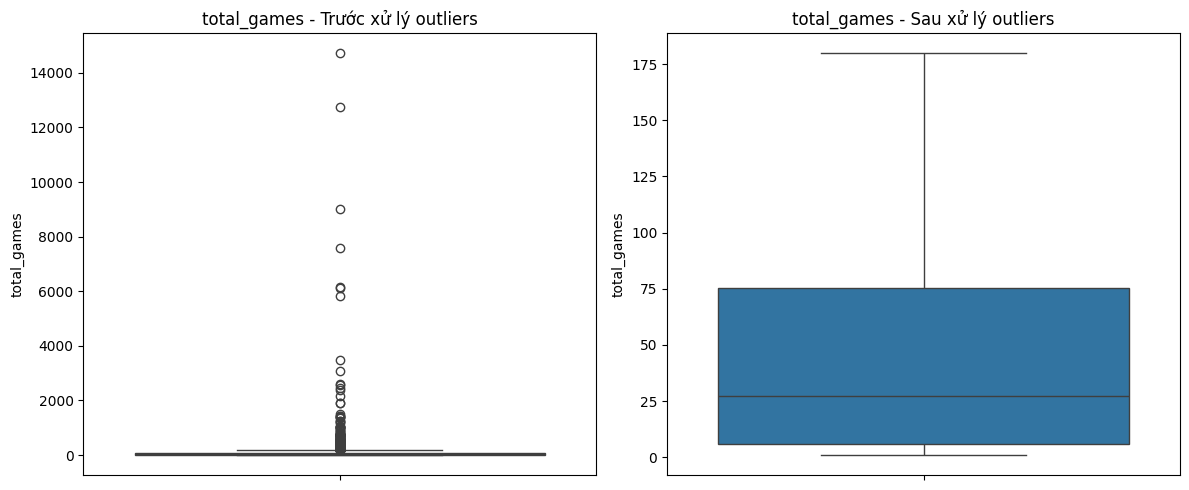

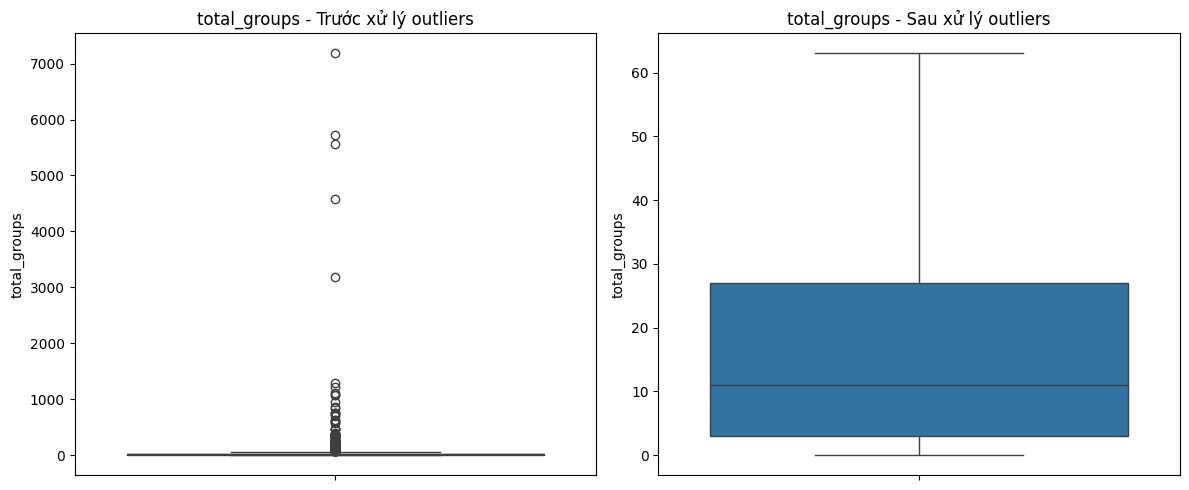

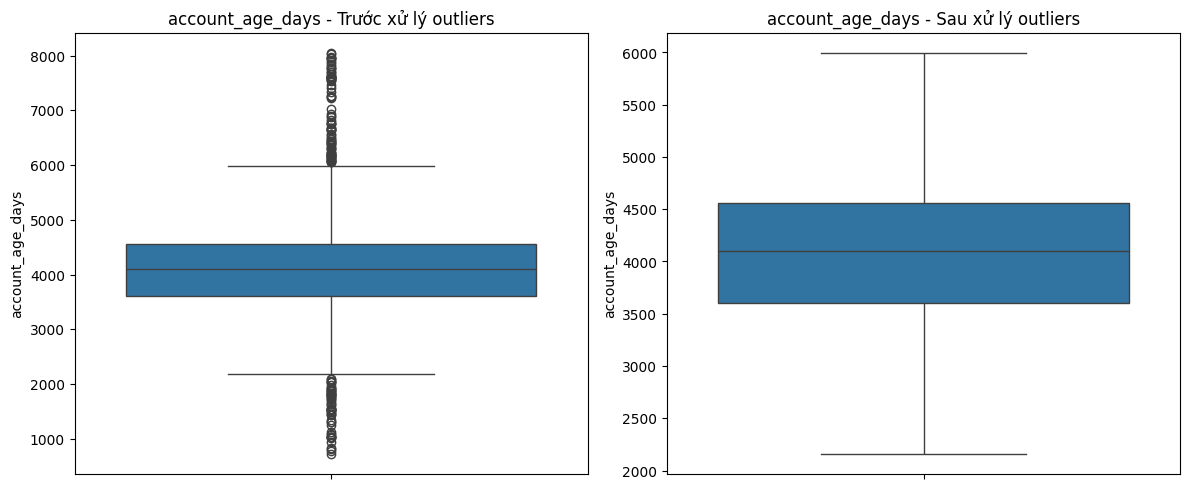

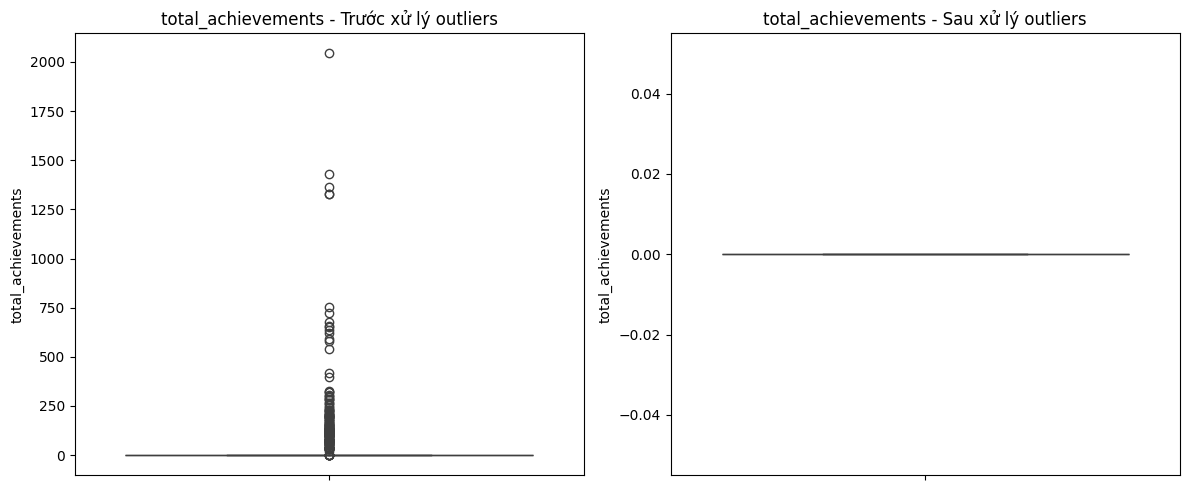

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Bước 1: Đọc dữ liệu trước và sau xử lý outliers ---
df_before = pd.read_csv('data_users1.csv')      # trước xử lý outliers
df_after = pd.read_csv('data_users2.csv')       # sau xử lý outliers

numeric_cols = ['total_games', 'total_groups', 'account_age_days', 'total_achievements']

# --- Bước 2: Vẽ boxplot so sánh trước và sau ---
for col in numeric_cols:
    plt.figure(figsize=(12,5))
    
    # Boxplot trước xử lý
    plt.subplot(1,2,1)
    sns.boxplot(y=df_before[col])
    plt.title(f'{col} - Trước xử lý outliers')
    
    # Boxplot sau xử lý
    plt.subplot(1,2,2)
    sns.boxplot(y=df_after[col])
    plt.title(f'{col} - Sau xử lý outliers')
    
    plt.tight_layout()
    plt.show()


XỬ LÝ TIMECREATED

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

# 1 XỬ LÝ TIMECREATED - TÁCH THÀNH 2 NHÓM
print(f"\n XỬ LÝ TIMECREATED")
print(f"Dòng có timecreated: {df['timecreated'].notna().sum()}")
print(f"Dòng không có timecreated: {df['timecreated'].isna().sum()}")

# Tạo cột datetime chỉ cho dòng có timecreated
df['account_created'] = pd.to_datetime(df['timecreated'], unit='s', errors='coerce')
df['account_age_days'] = (datetime.now() - df['account_created']).dt.days



 XỬ LÝ TIMECREATED
Dòng có timecreated: 1955
Dòng không có timecreated: 0



 PHÂN TÍCH TUỔI TÀI KHOẢN 
 SỐ TÀI KHOẢN ĐƯỢC TẠO THEO NĂM:
  2003: 6 tài khoản
  2004: 19 tài khoản
  2005: 10 tài khoản
  2006: 4 tài khoản
  2007: 16 tài khoản
  2008: 23 tài khoản
  2009: 31 tài khoản
  2010: 46 tài khoản
  2011: 106 tài khoản
  2012: 172 tài khoản
  2013: 268 tài khoản
  2014: 531 tài khoản
  2015: 275 tài khoản
  2016: 198 tài khoản
  2017: 112 tài khoản
  2018: 59 tài khoản
  2019: 22 tài khoản
  2020: 23 tài khoản
  2021: 17 tài khoản
  2022: 12 tài khoản
  2023: 5 tài khoản

 THỐNG KÊ :
  • Tuổi trung bình: 4127 ngày (~11.3 năm)
  • Tuổi trung vị: 4102 ngày
  • Tài khoản cũ nhất: 8050 ngày (~22.1 năm)
  • Tài khoản mới nhất: 731 ngày (~2.0 năm)


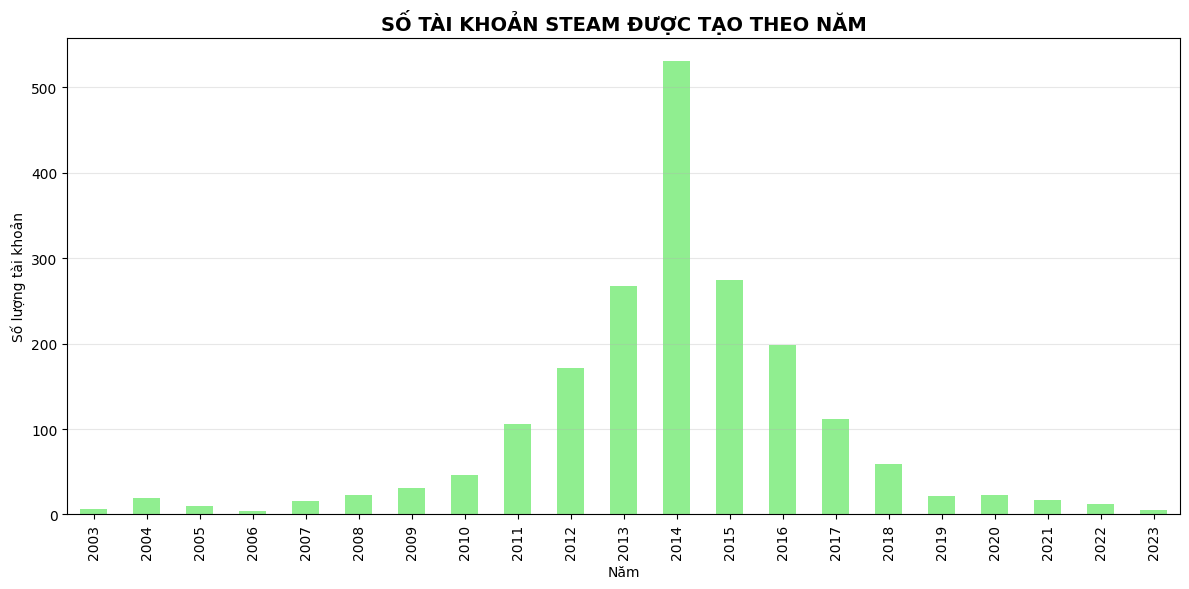

In [23]:
# 5. PHÂN TÍCH THỜI GIAN (CHỈ CHO USER CÓ TIMECREATED)

print("\n PHÂN TÍCH TUỔI TÀI KHOẢN ")

users_with_timecreated = df[df['timecreated'].notna()]

if len(users_with_timecreated) > 0:
    # Phân bố theo năm
    users_with_timecreated['year_created'] = users_with_timecreated['account_created'].dt.year
    yearly_creation = users_with_timecreated['year_created'].value_counts().sort_index()
    
    print(" SỐ TÀI KHOẢN ĐƯỢC TẠO THEO NĂM:")
    for year, count in yearly_creation.items():
        print(f"  {year}: {count} tài khoản")
    
    # Thống kê tuổi tài khoản
    print(f"\n THỐNG KÊ :")
    print(f"  • Tuổi trung bình: {users_with_timecreated['account_age_days'].mean():.0f} ngày (~{users_with_timecreated['account_age_days'].mean()/365:.1f} năm)")
    print(f"  • Tuổi trung vị: {users_with_timecreated['account_age_days'].median():.0f} ngày")
    print(f"  • Tài khoản cũ nhất: {users_with_timecreated['account_age_days'].max():.0f} ngày (~{users_with_timecreated['account_age_days'].max()/365:.1f} năm)")
    print(f"  • Tài khoản mới nhất: {users_with_timecreated['account_age_days'].min():.0f} ngày (~{users_with_timecreated['account_age_days'].min()/365:.1f} năm)")
    
    # Biểu đồ năm tạo tài khoản
    plt.figure(figsize=(12, 6))
    yearly_creation.plot(kind='bar', color='lightgreen')
    plt.title('SỐ TÀI KHOẢN STEAM ĐƯỢC TẠO THEO NĂM', fontsize=14, fontweight='bold')
    plt.xlabel('Năm')
    plt.ylabel('Số lượng tài khoản')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [14]:

# 3. PHÂN TÍCH TỔNG QUAN
print("PHÂN TÍCH TỔNG QUAN - 1949 USER STEAM")
# Thống kê cơ bản
has_realname = df['realname'].notna().sum()
has_country = df['loccountrycode'].notna().sum()

print(f" THỐNG KÊ PROFILE:")
print(f"• Có tên thật: {has_realname}/{len(df)} ({has_realname/len(df)*100:.1f}%)")
print(f"• Có quốc gia: {has_country}/{len(df)} ({has_country/len(df)*100:.1f}%)")
print(f"• Có timecreated: {df['timecreated'].notna().sum()}/{len(df)} ({(df['timecreated'].notna().sum()/len(df))*100:.1f}%)")


    


PHÂN TÍCH TỔNG QUAN - 1949 USER STEAM
 THỐNG KÊ PROFILE:
• Có tên thật: 910/1949 (46.7%)
• Có quốc gia: 1349/1949 (69.2%)
• Có timecreated: 1772/1949 (90.9%)



PHÂN TÍCH ĐỊA LÝ NGƯỜI DÙNG
 TOP 10 QUỐC GIA:
  VN: 1238 users (91.8%)
  US: 111 users (8.2%)
  JP: 51 users (3.8%)
  GB: 46 users (3.4%)
  DE: 42 users (3.1%)
  RU: 33 users (2.4%)
  FR: 31 users (2.3%)
  CA: 28 users (2.1%)
  CN: 22 users (1.6%)
  KR: 20 users (1.5%)


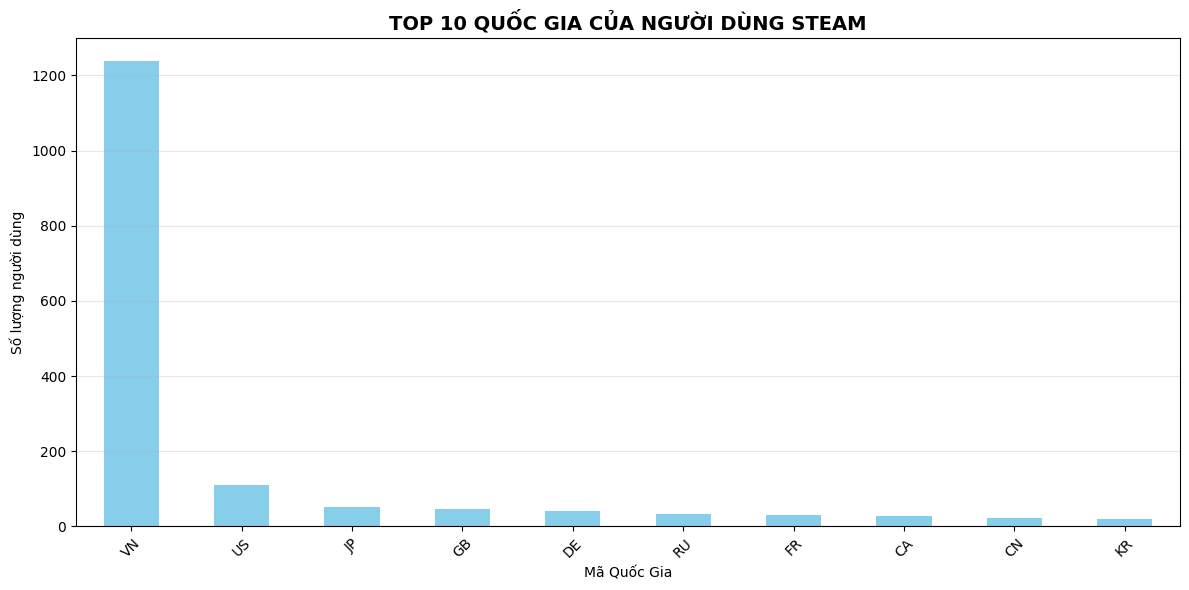

In [24]:
# 4. PHÂN TÍCH ĐỊA LÝ
print("\n" + "="*60)
print("PHÂN TÍCH ĐỊA LÝ NGƯỜI DÙNG")
print("="*60)

if has_country > 0:
    country_stats = df['loccountrycode'].value_counts().head(10)
    print(" TOP 10 QUỐC GIA:")
    for country, count in country_stats.items():
        percentage = (count / has_country) * 100
        print(f"  {country}: {count} users ({percentage:.1f}%)")
    
    # Biểu đồ quốc gia
    plt.figure(figsize=(12, 6))
    country_stats.head(10).plot(kind='bar', color='skyblue')
    plt.title('TOP 10 QUỐC GIA CỦA NGƯỜI DÙNG STEAM', fontsize=14, fontweight='bold')
    plt.xlabel('Mã Quốc Gia')
    plt.ylabel('Số lượng người dùng')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print(" Lỗi ")



In [16]:
# 3. PHÂN TÍKH KHÁM PHÁ (EDA) - TRẢ LỜI CÂU HỎI CƠ BẢN

print("PHÂN TÍCH TỔNG QUAN")
# Phân bố trạng thái online
print("\nPHÂN BỐ TRẠNG THÁI ONLINE:")
print(df['personastate'].value_counts())









PHÂN TÍCH TỔNG QUAN

PHÂN BỐ TRẠNG THÁI ONLINE:
personastate
0.0    1771
1.0      92
3.0      36
4.0      22
Name: count, dtype: int64
